In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

In [8]:
messages = [line.rstrip() for line in open('D:\\Google 雲端硬碟\\000-PYTHON程式區\\smsspamcollection\\SMSSpamCollection')]
print(len(messages))

UnicodeDecodeError: 'cp950' codec can't decode byte 0xa1 in position 573: illegal multibyte sequence

In [9]:
for message_no, message in enumerate(messages[:10]):
    print(message_no,message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, ￡1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea ￡900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

In [10]:
messages = pandas.read_csv('D:\\Google 雲端硬碟\\000-PYTHON程式區\\smsspamcollection\\SMSSpamCollection',
                           sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...
10     ham  I'm gonna be home soon and i don't want to tal...
11    spam  SIX chances to win CASH! From 100 to 20,000 po...
12    spam  URGENT! You have won a 1 week FREE membership ...
13     ham  I've been searching for the right words to tha...
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15    sp

In [11]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4827
      unique                                               4518
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In [12]:
messages['length'] = messages['message'].map(lambda text: len(text))
print(messages.head())

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


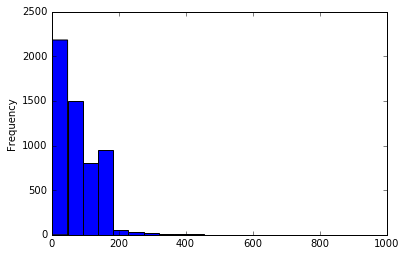

In [13]:
messages.length.plot(bins=20, kind='hist')

In [14]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [15]:
print(list(messages.message[messages.length > 900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF089B6A90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001FF089070F0>], dtype=object)

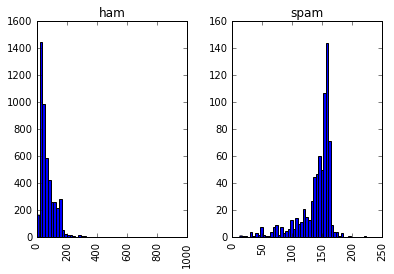

In [16]:
messages.hist(column='length', by='label', bins=50)

In [23]:
def split_into_tokens(message):
    message = str(message)  # convert bytes into proper unicode
    return TextBlob(message).words

In [24]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [25]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

In [26]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

In [27]:
def split_into_lemmas(message):
    message = str(message).lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

In [28]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

8850


In [29]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [30]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 1158)	1
  (0, 1897)	1
  (0, 2893)	1
  (0, 2923)	1
  (0, 4015)	1
  (0, 6724)	2
  (0, 7100)	1
  (0, 7684)	1
  (0, 7999)	2
(1, 8850)


In [31]:
print(bow_transformer.get_feature_names()[6736])
print(bow_transformer.get_feature_names()[8013])

scenario
uh


In [32]:
messages_bow = bow_transformer.transform(messages['message'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5574, 8850)
number of non-zeros: 80299
sparsity: 0.16%


In [33]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 7999)	0.291105194266
  (0, 7684)	0.226335054511
  (0, 7100)	0.192269693359
  (0, 6724)	0.525775845831
  (0, 4015)	0.458451720699
  (0, 2923)	0.331190492105
  (0, 2893)	0.305088635506
  (0, 1897)	0.24777643376
  (0, 1158)	0.276197347947


In [34]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

2.70735237731
8.23975323521


In [35]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5574, 8850)


In [44]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

Wall time: 58 ms


In [45]:
print('predicted:', spam_detector.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


In [46]:
all_predictions = spam_detector.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


In [47]:
print ('accuracy', accuracy_score(messages['label'], all_predictions))
print ('confusion matrix\n', confusion_matrix(messages['label'], all_predictions))
print ('(row=expected, col=predicted)')

accuracy 0.969501255831
confusion matrix
 [[4827    0]
 [ 170  577]]
(row=expected, col=predicted)


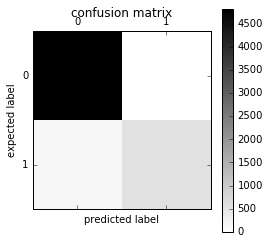

In [48]:
plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [49]:
print(classification_report(messages['label'], all_predictions))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5574

